# Section 1
This section is dedicated to the preparation of the data frames used in the subsequent sections.

## Characteristics dataframe
The first csv file contains the overall characteristics of each recorded accident such as the location, the luminosity, the type of road, and the precise date and time of the accident.

### Python imports

In [1]:
import pandas as pd
import numpy as np

from pandas import DataFrame,Series
%matplotlib inline

### First look at the data structure

In [2]:
caract_df = pd.read_csv("data/2014_France_caracteristiques.csv",sep=',', encoding='latin-1')

In [3]:
caract_df.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep
0,201400000001,14,5,7,2015,1,2,1,1.0,3,11,route de don,M,0.0,0.0,590
1,201400000002,14,5,31,430,1,2,1,1.0,6,11,106 ROUTE DE DON,M,0.0,0.0,590
2,201400000003,14,8,23,1800,1,2,9,1.0,3,52,75 bis rue jean jaures,M,0.0,0.0,590
3,201400000004,14,6,12,1700,1,2,1,1.0,1,25,rue des Sablonnieres D41,M,0.0,0.0,590
4,201400000005,14,6,23,500,2,1,1,1.0,1,25,NaN,M,0.0,0.0,590


The date is saved in many columns which is not necessarily practical. Also the format for the time is not too handy.
The column labels are quite cryptic and not just because they are in French.

### Convert time and date to datetime

In [4]:
import datetime as dt

The time of the accident is stored in an integer in 24H format such that 5:20pm becomes 1720.
However some of the strings are "1" or "15" or "29".
One possible explanation is that the recorded number was "029" for 29 minutes past midnight but once converted to an integer it became "29".
We can verify this by plotting the two distributions of values for hrmn > 100 (the hour after midnight) and hrmn >= 2300 (the hour before midnight), and compare them.

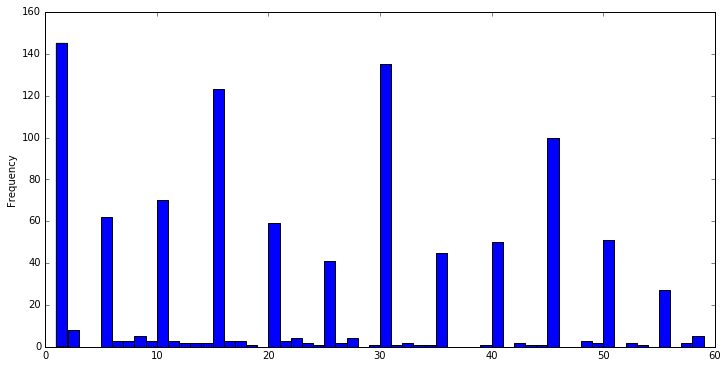

In [5]:
# The hour after midnight
caract_df[caract_df['hrmn'] < 100]['hrmn'].plot.hist(bins=range(1,60),figsize=(12,6))

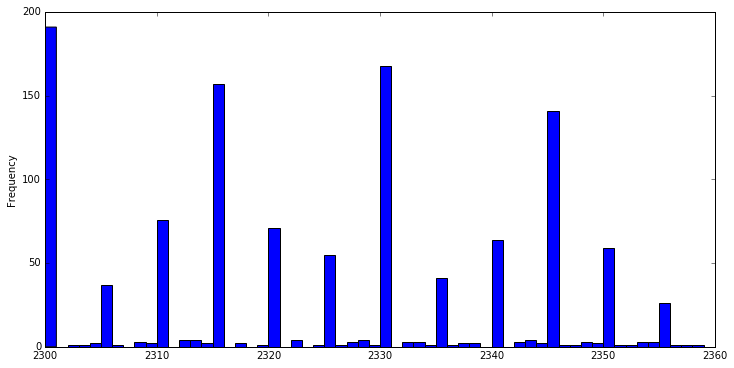

In [6]:
# The hour before midnight
caract_df[caract_df['hrmn'] >= 2300]['hrmn'].plot.hist(bins=range(2300,2360),figsize=(12,6))

We can now confidently convert integers < 100 to strings 4-character long and starting with 0.

In [7]:
def columns_to_datetime(sr):
    stringall = "%d-%d-%d %04d" % (sr['an'], sr['mois'], sr['jour'], sr['hrmn'])
    sr = sr.append(pd.Series(dt.datetime.strptime(stringall, "%y-%m-%d %H%M"), index=["datetime"]))
    return sr

In [8]:
clean_df = caract_df.apply(columns_to_datetime,axis=1)

In [9]:
clean_df.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,datetime
0,201400000001,14,5,7,2015,1,2,1,1.0,3,11,route de don,M,0.0,0.0,590,2014-05-07 20:15:00
1,201400000002,14,5,31,430,1,2,1,1.0,6,11,106 ROUTE DE DON,M,0.0,0.0,590,2014-05-31 04:30:00
2,201400000003,14,8,23,1800,1,2,9,1.0,3,52,75 bis rue jean jaures,M,0.0,0.0,590,2014-08-23 18:00:00
3,201400000004,14,6,12,1700,1,2,1,1.0,1,25,rue des Sablonnieres D41,M,0.0,0.0,590,2014-06-12 17:00:00
4,201400000005,14,6,23,500,2,1,1,1.0,1,25,NaN,M,0.0,0.0,590,2014-06-23 05:00:00


In [10]:
# Let's check that our conversion worked properly
clean_df[clean_df['hrmn'] == 29]

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,datetime
20746,201400020747,14,7,4,29,5,2,2,1.0,3,231,MARECHAL LYAUTEY (AVENUE,NaN,NaN,NaN,210,2014-07-04 00:29:00


In [11]:
# We can remove the original time and date columns
clean_df.drop(['an','mois','jour','hrmn'],axis=1, inplace=True)
clean_df.head()

,Num_Acc,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,datetime
0,201400000001,1,2,1,1.0,3,11,route de don,M,0.0,0.0,590,2014-05-07 20:15:00
1,201400000002,1,2,1,1.0,6,11,106 ROUTE DE DON,M,0.0,0.0,590,2014-05-31 04:30:00
2,201400000003,1,2,9,1.0,3,52,75 bis rue jean jaures,M,0.0,0.0,590,2014-08-23 18:00:00
3,201400000004,1,2,1,1.0,1,25,rue des Sablonnieres D41,M,0.0,0.0,590,2014-06-12 17:00:00
4,201400000005,2,1,1,1.0,1,25,NaN,M,0.0,0.0,590,2014-06-23 05:00:00


### Remove unreliable information
The precise location of the accident has not been reliably recorded so we won't be able for example to get a reliable map of the location of the accidents.

In [12]:
clean_df.isnull().sum()

Num_Acc         0
lum             0
agg             0
int             0
atm            16
col             0
com             0
adr          9602
gps         28894
lat         29273
long        29273
dep             0
datetime        0
dtype: int64

In [13]:
clean_df.shape

(59854, 13)

Half of the longitude, latitude and the gps variable are missing. Many of the adresses are also missing and we don't have any use for a very precise location so we can drop them. We still have the area code ("dep") for a rough location in France.

In [14]:
clean_df.drop(['adr','gps','lat','long'],axis=1, inplace=True)
clean_df.head()

,Num_Acc,lum,agg,int,atm,col,com,dep,datetime
0,201400000001,1,2,1,1.0,3,11,590,2014-05-07 20:15:00
1,201400000002,1,2,1,1.0,6,11,590,2014-05-31 04:30:00
2,201400000003,1,2,9,1.0,3,52,590,2014-08-23 18:00:00
3,201400000004,1,2,1,1.0,1,25,590,2014-06-12 17:00:00
4,201400000005,2,1,1,1.0,1,25,590,2014-06-23 05:00:00


### Rename the columns
Some of the column names are a little cryptic such as "col". Let's clarify them.

In [15]:
clean_df.rename(columns={'Num_Acc':'accident id','lum':'luminosity','agg':'in city','int':'intersect type',
                         'atm':'weather','col':'collision type','com':'city id','dep':'area id'},
                inplace=True)
clean_df.head()

,accident id,luminosity,in city,intersect type,weather,collision type,city id,area id,datetime
0,201400000001,1,2,1,1.0,3,11,590,2014-05-07 20:15:00
1,201400000002,1,2,1,1.0,6,11,590,2014-05-31 04:30:00
2,201400000003,1,2,9,1.0,3,52,590,2014-08-23 18:00:00
3,201400000004,1,2,1,1.0,1,25,590,2014-06-12 17:00:00
4,201400000005,2,1,1,1.0,1,25,590,2014-06-23 05:00:00


### Area ID correction
For some reason most area IDs have an added 0 except for the overseas areas 971, 973, 974, and 976.

In [16]:
clean_df['area id'].unique()

array([590, 620, 800,  20, 600, 570, 760, 270, 350, 220, 290, 560, 140,
       500, 940,  10, 610, 440, 490, 530, 720, 850, 330,  40, 240, 400,
       470, 640, 860, 160, 170, 790, 870, 190, 230, 310,  90, 120, 320,
       650, 460, 810, 690, 820,  70, 260, 380, 420, 730, 740, 630,  30,
       150, 430, 540, 550, 880, 670, 680, 510,  80, 100, 520, 210, 580,
       710, 890, 250, 390, 700, 900, 130,  50,  60, 830, 840, 340, 110,
       300, 480, 660, 201, 202, 780, 910, 950, 770, 450, 180, 280, 360,
       370, 410, 920, 930, 750, 972, 971, 973, 974, 976])

Let's correct those for clarity sake.

In [17]:
def correct_area_id(sr):
    if sr['area id'] < 970:
        sr['area id'] = int(sr['area id'] /10)
    return sr
clean_df = clean_df.apply(correct_area_id,axis=1)

In [18]:
clean_df['area id'].unique()

array([ 59,  62,  80,   2,  60,  57,  76,  27,  35,  22,  29,  56,  14,
        50,  94,   1,  61,  44,  49,  53,  72,  85,  33,   4,  24,  40,
        47,  64,  86,  16,  17,  79,  87,  19,  23,  31,   9,  12,  32,
        65,  46,  81,  69,  82,   7,  26,  38,  42,  73,  74,  63,   3,
        15,  43,  54,  55,  88,  67,  68,  51,   8,  10,  52,  21,  58,
        71,  89,  25,  39,  70,  90,  13,   5,   6,  83,  84,  34,  11,
        30,  48,  66,  20,  78,  91,  95,  77,  45,  18,  28,  36,  37,
        41,  92,  93,  75, 972, 971, 973, 974, 976])

### Store characteristics dataframe
We can now save this dataframe to reuse it in another section/notebook.

In [19]:
store = pd.HDFStore('data/2014_France.h5')
store.put('characteristics',clean_df)

## Locations dataframe
The second csv file contains the details of the accident's location.

In [20]:
lieux_df = pd.read_csv("data/2014_France_lieux.csv",sep=',', encoding='latin-1')

In [21]:
lieux_df.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
0,201400000001,3,41.0,NaN,NaN,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,60.0,1.0,0.0,1.0,0.0
1,201400000002,3,41.0,NaN,NaN,2.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,62.0,1.0,0.0,4.0,99.0
2,201400000003,3,39.0,NaN,NaN,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,60.0,1.0,0.0,1.0,99.0
3,201400000004,3,41.0,NaN,NaN,2.0,2.0,0.0,800.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,1.0,99.0
4,201400000005,3,141.0,NaN,NaN,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0


### Remove useless information
Let's check which information we can drop.

In [22]:
lieux_df.isnull().sum()

Num_Acc        0
catr           0
voie        3860
v1         59610
v2         57994
circ          79
nbv          142
pr         32641
pr1        32828
vosp         188
prof         144
plan         143
lartpc      1670
larrout     1530
surf         147
infra        112
situ          99
env1         123
dtype: int64

In [23]:
lieux_df.shape

(59854, 18)

Some of the most unreliable columns are fortunately also not very useful since they pertain to the address of the accident which we have already decided to drop.

In [24]:
clean_df = lieux_df.drop(['voie','v1','v2','pr','pr1'],axis=1)
clean_df.head()

,Num_Acc,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
0,201400000001,3,2.0,0.0,0.0,1.0,1.0,0.0,60.0,1.0,0.0,1.0,0.0
1,201400000002,3,2.0,2.0,0.0,1.0,2.0,0.0,62.0,1.0,0.0,4.0,99.0
2,201400000003,3,2.0,0.0,0.0,1.0,1.0,0.0,60.0,1.0,0.0,1.0,99.0
3,201400000004,3,2.0,2.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,1.0,99.0
4,201400000005,3,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0


### Rename columns
Again work is needed to clarify the meaning of each column.

In [25]:
clean_df.rename(columns={'Num_Acc':'accident id','catr':'road type','circ':'traffic mode',
                         'nbv':'nb lanes','vosp':'reserved lane','prof':'road profil',
                         'plan':'road alignment','lartpc':'central reservation',
                         'larrout':'road width','surf':'road surface','infra':'installations',
                         'situ':'location','env1':'school distance'},
                inplace=True)
clean_df.head()

,accident id,road type,traffic mode,nb lanes,reserved lane,road profil,road alignment,central reservation,road width,road surface,installations,location,school distance
0,201400000001,3,2.0,0.0,0.0,1.0,1.0,0.0,60.0,1.0,0.0,1.0,0.0
1,201400000002,3,2.0,2.0,0.0,1.0,2.0,0.0,62.0,1.0,0.0,4.0,99.0
2,201400000003,3,2.0,0.0,0.0,1.0,1.0,0.0,60.0,1.0,0.0,1.0,99.0
3,201400000004,3,2.0,2.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,1.0,99.0
4,201400000005,3,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0


### Store locations dataframe
Time to store this additional dataframe.

In [26]:
store.put('Locations',clean_df)

## Vehicle dataframe
All the details of the vehicles involved in the accident are listed in this dataframe. This time the same accident ID can appear in more than one entry since each entry is one of the vehicles involved in the accident.

In [27]:
vehicules_df = pd.read_csv("data/2014_France_vehicules.csv",sep=',', encoding='latin-1')

In [28]:
vehicules_df.head()

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh
0,201400000001,0,33,0,0.0,2.0,1.0,1.0,A01
1,201400000001,0,7,0,0.0,0.0,6.0,15.0,B02
2,201400000002,0,7,0,1.0,0.0,7.0,13.0,A01
3,201400000003,0,2,0,0.0,2.0,1.0,1.0,A01
4,201400000003,0,7,0,0.0,2.0,7.0,15.0,B02


### Remove columns
Most columns are really useful except for the traffic sense which has mostly zeroes meaning that the sense wasn't recorded. We can remove it.

In [29]:
vehicules_df['senc'].value_counts().head()

0    98441
1     2862
2      459
Name: senc, dtype: int64

In [30]:
clean_df = vehicules_df.drop('senc',axis=1)

In [31]:
clean_df.head()

,Num_Acc,catv,occutc,obs,obsm,choc,manv,num_veh
0,201400000001,33,0,0.0,2.0,1.0,1.0,A01
1,201400000001,7,0,0.0,0.0,6.0,15.0,B02
2,201400000002,7,0,1.0,0.0,7.0,13.0,A01
3,201400000003,2,0,0.0,2.0,1.0,1.0,A01
4,201400000003,7,0,0.0,2.0,7.0,15.0,B02


### Rename columns
And now the renaming of the columns.

In [32]:
clean_df.rename(columns={'Num_Acc':'accident id', 'catv':'vehicle type','obs':'fixed obj hit',
                         'obsm':'moving obj hit', 'choc':'initial hit location','manv':'maneuver',
                         'occutc':'nb occupants public transit', 'num_veh':'vehicle id'},inplace=True)

In [33]:
clean_df.head()

,accident id,vehicle type,nb occupants public transit,fixed obj hit,moving obj hit,initial hit location,maneuver,vehicle id
0,201400000001,33,0,0.0,2.0,1.0,1.0,A01
1,201400000001,7,0,0.0,0.0,6.0,15.0,B02
2,201400000002,7,0,1.0,0.0,7.0,13.0,A01
3,201400000003,2,0,0.0,2.0,1.0,1.0,A01
4,201400000003,7,0,0.0,2.0,7.0,15.0,B02


### Store vehicles dataframe

In [34]:
store.put('Vehicles',clean_df)

## Users dataframe
This final dataframe contains the information relative to the people or road users involved in the accident. The dataframe contains both personal information on the users such as their birthdate or their sex, but it also has for example information on the safety gear worn, the location and direction of the pedestrians hit.

In [35]:
usagers_df = pd.read_csv("data/2014_France_usagers.csv",sep=',', encoding='latin-1')

In [36]:
usagers_df.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh
0,201400000001,1.0,1,3,1,5.0,21.0,0.0,0.0,0.0,1971.0,A01
1,201400000001,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1992.0,B02
2,201400000002,1.0,1,4,1,5.0,11.0,0.0,0.0,0.0,1983.0,A01
3,201400000002,2.0,2,3,1,0.0,11.0,0.0,0.0,0.0,1990.0,A01
4,201400000003,1.0,1,3,1,5.0,21.0,0.0,0.0,0.0,1974.0,A01


We will keep all the columns of this dataframe since they all contain some interesting data.

### Reformat columns
The 'secu' and 'an_nais' columns represent respectively the safety gear used (or not used) and the birth year of each user.
The 'secu' is not too practical to use as it is since it store the type of safety gear in the first digit, and if the safety gear was used or not in the second digit of an integer. It will be simpler to have 2 columns for these two items.

In [37]:
usagers_df['secu'].value_counts(dropna=False)

 11.0    72958
 21.0    23671
 93.0    11646
 13.0    11179
NaN       4035
 23.0     2645
 12.0     1911
 22.0     1281
 31.0      996
 91.0      546
 92.0      429
 1.0       301
 41.0      222
 43.0      120
 42.0      118
 32.0       47
 33.0       46
 2.0        19
 3.0        16
Name: secu, dtype: int64

We should always have the first digit since the value 9 represent 'others' for non-defined types.

In [38]:
def safety_to_twocolumns(sr):
    if not np.isnan(sr['secu']):
        safetychar = "%2d" % (sr['secu'])
        if safetychar[0] != ' ':
            sr = sr.append(pd.Series(int(safetychar[0]), index=["safety gear type"]))
        sr = sr.append(pd.Series(int(safetychar[1]), index=["safety gear worn"]))
    return sr

In [39]:
clean_df = usagers_df.apply(safety_to_twocolumns,axis=1)

In [40]:
clean_df.head()

,Num_Acc,actp,an_nais,catu,etatp,grav,locp,num_veh,place,safety gear type,safety gear worn,secu,sexe,trajet
0,201400000001,0.0,1971.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,21.0,1,5.0
1,201400000001,0.0,1992.0,1,0.0,1,0.0,B02,1.0,1.0,1.0,11.0,1,5.0
2,201400000002,0.0,1983.0,1,0.0,4,0.0,A01,1.0,1.0,1.0,11.0,1,5.0
3,201400000002,0.0,1990.0,2,0.0,3,0.0,A01,2.0,1.0,1.0,11.0,1,0.0
4,201400000003,0.0,1974.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,21.0,1,5.0


In [41]:
clean_df.drop('secu',inplace=True,axis=1)
clean_df.head()

,Num_Acc,actp,an_nais,catu,etatp,grav,locp,num_veh,place,safety gear type,safety gear worn,sexe,trajet
0,201400000001,0.0,1971.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0
1,201400000001,0.0,1992.0,1,0.0,1,0.0,B02,1.0,1.0,1.0,1,5.0
2,201400000002,0.0,1983.0,1,0.0,4,0.0,A01,1.0,1.0,1.0,1,5.0
3,201400000002,0.0,1990.0,2,0.0,3,0.0,A01,2.0,1.0,1.0,1,0.0
4,201400000003,0.0,1974.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0


The birth year is not that interesting by itself. The age of the users seems more interesting. We can replace the birth year by the age.

In [42]:
clean_df['age'] = 2014 - clean_df['an_nais']

In [43]:
clean_df.drop('an_nais',inplace=True,axis=1)
clean_df.head()

,Num_Acc,actp,catu,etatp,grav,locp,num_veh,place,safety gear type,safety gear worn,sexe,trajet,age
0,201400000001,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,43.0
1,201400000001,0.0,1,0.0,1,0.0,B02,1.0,1.0,1.0,1,5.0,22.0
2,201400000002,0.0,1,0.0,4,0.0,A01,1.0,1.0,1.0,1,5.0,31.0
3,201400000002,0.0,2,0.0,3,0.0,A01,2.0,1.0,1.0,1,0.0,24.0
4,201400000003,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,40.0


### Rename the columns

In [44]:
clean_df.rename(columns={'Num_Acc':'accident id', 'num_veh':'vehicle id',
                         'place':'location in vehicle','catu':'user type',
                         'grav':'gravity','sexe':'sex','trajet':'journey type',
                         'locp':'pedestrian location','actp':'pedestrian action',
                         'etatp':'pedestrian company'},inplace=True)

In [45]:
clean_df.head()

,accident id,pedestrian action,user type,pedestrian company,gravity,pedestrian location,vehicle id,location in vehicle,safety gear type,safety gear worn,sex,journey type,age
0,201400000001,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,43.0
1,201400000001,0.0,1,0.0,1,0.0,B02,1.0,1.0,1.0,1,5.0,22.0
2,201400000002,0.0,1,0.0,4,0.0,A01,1.0,1.0,1.0,1,5.0,31.0
3,201400000002,0.0,2,0.0,3,0.0,A01,2.0,1.0,1.0,1,0.0,24.0
4,201400000003,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,40.0


### Store users dataframe
Our last dataframe is now ready !

In [46]:
store.put('Users',clean_df)

In [47]:
store.close()